# Initialization

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# for image data handling
import os
from os.path import join, isfile, dirname
from PIL import Image

# Data Handling

### Uncompress compressed files

In [3]:
%%capture
!unzip -n ../data/images.zip -d ../data

### Custom functions

In [68]:
def genFromImage(imageDir, size=(8, 8)):
    dir = dirname(imageDir)
    dataFile = join(dir, "p4_data") + str(size) + ".npy"
    if isfile(dataFile):
        with open(dataFile, 'rb') as f:
            return np.load(f)
    
    labels = os.listdir(imageDir)
    image_data = [[] for _ in labels]
    for label in labels:
        dir = join(imageDir, label)
        files = os.listdir(dir)
        image_data[int(label)] = np.array([np.array(
            Image.open(join(dir, file)).convert("L").resize(size), dtype='uint8'
        ) for file in files])
        
    image_data = np.array(image_data)
    with open(dataFile, 'wb') as f:
        np.save(f, image_data)
    return image_data

# returns X, Y, X_test, Y_test and classStats
def trainTestSplit(data, train_ratio, func):
    n = len(data)
    m = int(np.floor(data.shape[1] * train_ratio))
    classStats = {}
    x_train, y_train, x_test, y_test = [[[] for _ in range(n)] for _ in range(4)]
    for label in range(n):
        x_train[label], y_train[label], classStats[label] = func(label, data[label][:m], True)
        x_test[label], y_test[label] = func(label, data[label][m:])
    
    X, Y, X_test, Y_test = [x.reshape(-1, x.shape[-1]) for x in [np.array(x) for x in [x_train, y_train, x_test, y_test]]]
    return X, np.array(Y.flatten(), dtype=int), X_test, np.array(Y_test.flatten(), dtype=int), classStats

def imgToFeatures(label, data, stats=False):
    X = np.array([x.flatten() for x in data]) / 255
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

def stats(label, data, stats=False):
    X = data
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

### Data extraction

In [69]:
dataFolder = "../data"
imageDir = join(dataFolder, "images")

# p1 = { "testDir": dataFolder + "/p1_test.csv", "trainDir": dataFolder + "/p1_train.csv" } # regression
# p2 = { "testDir": dataFolder + "/p2_test.csv", "trainDir": dataFolder + "/p2_train.csv" } # regression
p3 = { "testDir": dataFolder + "/p3_test.csv", "trainDir": dataFolder + "/p3_train.csv" } # classification
p4 = {}                                                                                   # classification
p5 = {}                                                                                   # classification

# p1["test"] = np.genfromtxt(p1["testDir"], delimiter=',')
# p1["train"] = np.genfromtxt(p1["trainDir"], delimiter=',')
# p2["test"] = np.genfromtxt(p2["testDir"], delimiter=',')
# p2["train"] = np.genfromtxt(p2["trainDir"], delimiter=',')
p3["test"] = np.genfromtxt(p3["testDir"], delimiter=',')
p3["train"] = np.genfromtxt(p3["trainDir"], delimiter=',')
p4["data"] = genFromImage(imageDir)
p5["data"] = np.genfromtxt(dataFolder + "/PCA_MNIST.csv", delimiter=',')[1:]

print("--------------------------- Data Shapes ------------------------------")
# print("    (Regression) p1[train]:      ", p1["train"].shape, ", p1[test]: ", p1["test"].shape)
# print("    (Regression) p2[train]:      ", p2["train"].shape, ", p2[test]: ", p2["test"].shape)
print("(Classification) p3[train]:     ", p3["train"].shape, ", p3[test]: ", p3["test"].shape)
print("(Classification)  p4[data]:", p4["data"].shape)
print("(Classification)  p5[data]:     ", p5["data"].shape)

--------------------------- Data Shapes ------------------------------
(Classification) p3[train]:      (60000, 11) , p3[test]:  (15000, 11)
(Classification)  p4[data]: (10, 6000, 8, 8)
(Classification)  p5[data]:      (60000, 11)


In [70]:
classStats = {}
for row in p3["train"]:
    label = int(row[-1]) - 1
    if label in classStats:
        classStats[label].append(row[:-1])
    else:
        classStats[label] = [row[:-1]]

# classStats = [np.array(data) for data in classStats]
for i in range(len(classStats)):
    data = np.array(classStats[i])
    classStats[i] = { "mean": np.mean(data, axis=0), "cov": np.cov(data.T), "prior": data.shape[0], "data": data }
    
def splitData(data):
    # X = np.array([normalize(col) for col in data.T[:-1]]).T
    X = data.T[:-1].T
    Y = data.T[-1].T.astype("int") - 1
    return X, Y

p3["classStats"] = classStats
p3["X"], p3["Y"] = splitData(p3["train"])
p3["X_test"], p3["Y_test"] = splitData(p3["test"])

p3["X"].shape, p3["Y"].shape, p3["X_test"].shape, p3["Y_test"].shape

((60000, 10), (60000,), (15000, 10), (15000,))

In [71]:
p4["X"], p4["Y"], p4["X_test"], p4["Y_test"], p4["classStats"] = trainTestSplit(p4["data"], 0.7, imgToFeatures)

p4["X"].shape, p4["Y"].shape, p4["X_test"].shape, p4["Y_test"].shape

((42000, 64), (42000,), (18000, 64), (18000,))

In [72]:
classWiseData = [[] for _ in range(10)]
for row in p5["data"]:
    label = int(row[0])
    classWiseData[label].append(row[1:])
    
p5["X"], p5["Y"], p5["X_test"], p5["Y_test"], p5["classStats"] = trainTestSplit(np.array(classWiseData), 0.5, stats)
p5["X"].shape, p5["Y"].shape, p5["X_test"].shape, p5["Y_test"].shape

((30000, 10), (30000,), (30000, 10), (30000,))

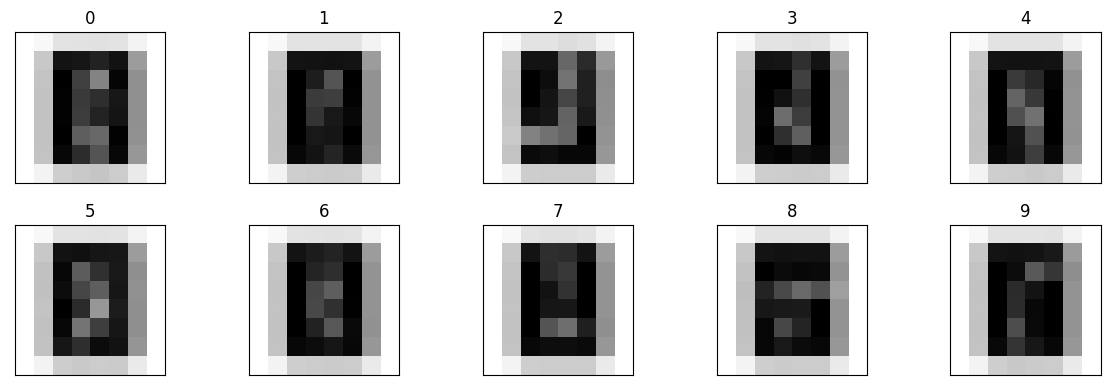

In [73]:
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
for i in range(p4["data"].shape[0]):
    ax[i // 5][i % 5].imshow(p4["data"][i][0].astype(np.uint8), cmap='gray')
    ax[i // 5][i % 5].set_title(str(i))
    ax[i // 5][i % 5].get_xaxis().set_visible(False)
    ax[i // 5][i % 5].get_yaxis().set_visible(False)

fig.tight_layout()

# Metrics

In [54]:
class metrics:
    def accuracy(predicted, actual):
        m = actual.size
        correctCount = sum([1 if int(predicted[i]) == int(actual[i]) else 0 for i in range(m)])
        return correctCount / m
    
    def confusionMatrix(predicted, actual, n = 5):
        cnf = np.zeros((n, n), dtype='uint')
        for i in range(actual.size):
            cnf[int(actual[i])][int(predicted[i])] += 1
        return cnf
    
    def f1Score(cnf):
        sum_predict = np.sum(cnf, axis=0)
        sum_actual  = np.sum(cnf, axis=1)
        f1 = np.zeros(cnf.shape[1])
        for i in range(f1.size):
            TP = cnf[i][i]
            FP, FN = sum_predict[i] - TP, sum_actual[i] - TP
            p, r = TP/(TP + FP + 1e-8), TP/(TP + FN + 1e-8)
            f1[i] = 2 * p * r / (p + r + 1e-8)
        return f1    

    def printCnf(cnf_train, cnf_test):
        print("Confusion Matrix:")
        print(cnf_test)
        
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].matshow(cnf_train.T, cmap='GnBu')
        ax[0].set_xlabel("Predicted")
        ax[0].set_ylabel("Actual")
        ax[0].set_title("Confusion Matrix (train)")
        for (x, y), value in np.ndenumerate(cnf_train):
            ax[0].text(x, y, f"{value: .0f}", va="center", ha="center")
        
        ax[1].matshow(cnf_test.T, cmap='GnBu')
        ax[1].set_xlabel("Predicted")
        ax[1].set_ylabel("Actual")
        ax[1].set_title("Confusion Matrix (test)")
        for (x, y), value in np.ndenumerate(cnf_test):
            ax[1].text(x, y, f"{value: .0f}", va="center", ha="center")

    
    def print(pred, Y, pred_test, Y_test, visualize=True, result=False):
        n_labels = len(np.unique(Y))
                
        cnf_train = metrics.confusionMatrix(pred, Y, n_labels)
        cnf_test = metrics.confusionMatrix(pred_test, Y_test, n_labels)
        acc_train = metrics.accuracy(pred, Y)
        acc_test = metrics.accuracy(pred_test, Y_test)
        f1_train = metrics.f1Score(cnf_train)
        f1_test = metrics.f1Score(cnf_test)
        
        if visualize:
            print("------------------ Train ---------------------")
            print("Classification Accuracy : ", acc_train * 100, "%")
            print("Average F1 Score                : ", np.average(f1_train))
            print("------------------ Test ----------------------")
            print("Classification Accuracy : ", acc_test * 100, "%")
            print("Average F1 Score                : ", np.average(f1_test))
            
            metrics.printCnf(cnf_train, cnf_test)
        
        if result:
            return [acc_train, f1_train, cnf_train], [acc_test, f1_test, cnf_test]

# Problem 1

Implement classification trees using Gini impurity and cross-entropy as impurity functions with different depths. 

For the MNIST problem, consider the PCA data

Data: `p3, p5`

## Implementation

### Impurity Funcions

In [49]:
def gini(data):
    n = data.shape[0]
    if n == 0:
        return 0
    p = np.bincount(data) / n
    return 1 - np.sum(p ** 2)

print("Gini (test): ", gini(p3["Y"]), gini(p3['Y'][p3["Y"] == 0]))

def entropy(data):
    n = data.shape[0]
    if n == 0:
        return 0
    p = np.bincount(data) / n
    return -np.sum(p * np.log2(p + 1e-8))

print("Entropy (test): ", entropy(p3["Y"]), entropy(p3['Y'][p3["Y"] == 0]))

Gini (test):  0.7999987455555555 0.0
Entropy (test):  2.3219234968181315 -1.442695024907551e-08


### CART algorithm

In [50]:
# restricting the number of thresholds to increase the speed of the algorithm
def recommendedThresholds(col, y):
    a = np.c_[col, y]
    a.sort(axis=0)
    b = []
    for i in range(1, a.shape[0]):
        if a[i][1] != a[i - 1][1]:
            b.append((a[i][0] + a[i - 1][0]) / 2)
    return b

def recommendedSplit(X, y, impurity):
    best_impurity = 1e9
    best_split = None
    for i, col in enumerate(X.T):
        ts = recommendedThresholds(col, y)
        for t in ts:
            left, right = y[col <= t], y[col > t]
            impurity_split = (impurity(left) * left.size + impurity(right) * right.size) / y.size
            if impurity_split < best_impurity:
                best_impurity = impurity_split
                best_split = (i, t)
    return best_split

recommendedSplit(p3["X"], p3["Y"], gini)

(5, 1.3925129339837405)

### Decision Tree

In [51]:
# inner nodes are [i, t, left, right]
# leaf node is a number (class label)
# returns a tree in pre-order traversal format
def buildTree(X, y, impurity, max_depth, depth=0):
    if depth == max_depth:
        return [np.argmax(np.bincount(y))]
    if np.unique(y).size == 1:
        return [y[0]]
    
    split = recommendedSplit(X, y, impurity)

    if split is None:
        return [np.argmax(np.bincount(y))]
    
    i, t = split
    left, right = y[X[:, i] <= t], y[X[:, i] > t]
    leftX, rightX = X[X[:, i] <= t], X[X[:, i] > t]

    if left.size == 0 or right.size == 0:
        return [np.argmax(np.bincount(y))]
    
    return [split, buildTree(leftX, left, impurity, max_depth, depth + 1), buildTree(rightX, right, impurity, max_depth, depth + 1)]

def printTree(tree, depth=0):
    if len(tree) == 1:
        print(" " * depth, "Leaf: ", tree[0])
    else:
        print(" " * depth, f"Split: {tree[0][0]:.2f} <=  {tree[0][1]:.2f}")
        printTree(tree[1], depth + 1)
        printTree(tree[2], depth + 1)

def predict(X, tree):
    if len(tree) == 1:
        return tree[0]
    i, t = tree[0]
    return predict(X, tree[1]) if X[i] <= t else predict(X, tree[2])
    
def predictAll(X, tree):
    return np.array([predict(x, tree) for x in X])


## Experiment on P3 Data

### Using Gini as impurity measure

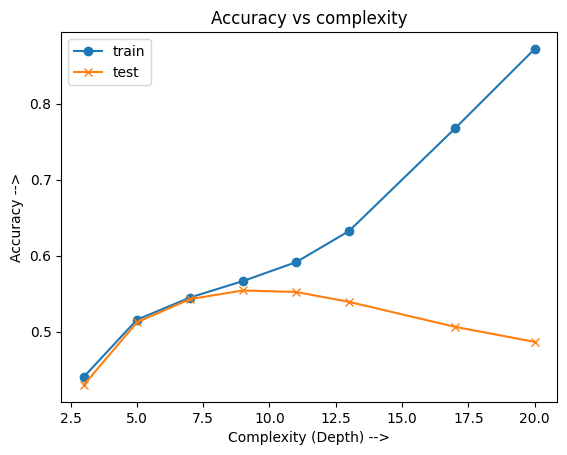

In [59]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p3["X"], p3["Y"], gini, depth)
    results.append(metrics.print(predictAll(p3["X"], tree), p3["Y"], predictAll(p3["X_test"], tree), p3["Y_test"], visualize=False, result=True))

bestResult_p3_gini = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 55.42%, F1 Score: 0.56
Confusion Matrix:
[[1551  589  251  287  293]
 [ 413 1808  275  262  223]
 [ 339  506 1804  198  193]
 [ 354  574  262 1608  177]
 [ 380  609  230  272 1542]]


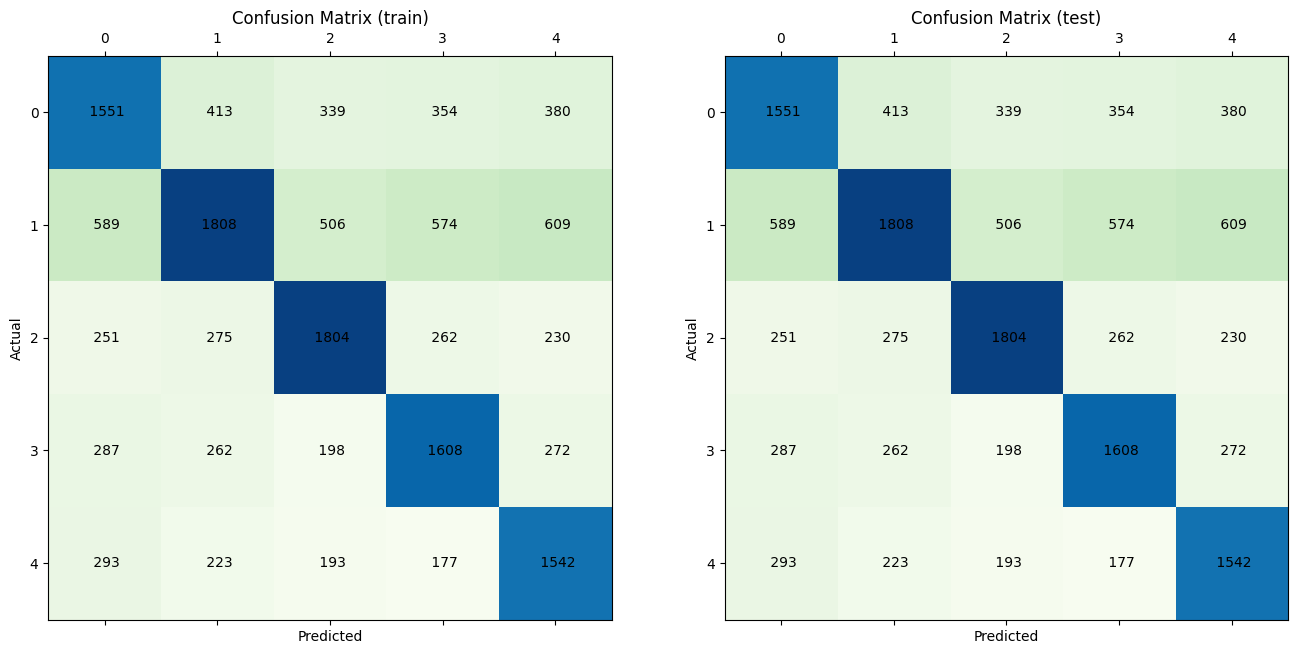

In [83]:
print(f"Test Accuracy: {bestResult_p3_gini[1][0] * 100:.2f}%, F1 Score: {np.average(bestResult_p3_gini[1][1]):.2f}")
metrics.printCnf(bestResult_p3_gini[1][2], bestResult_p3_gini[1][2])

### Using Cross-Entropy as impurity measure

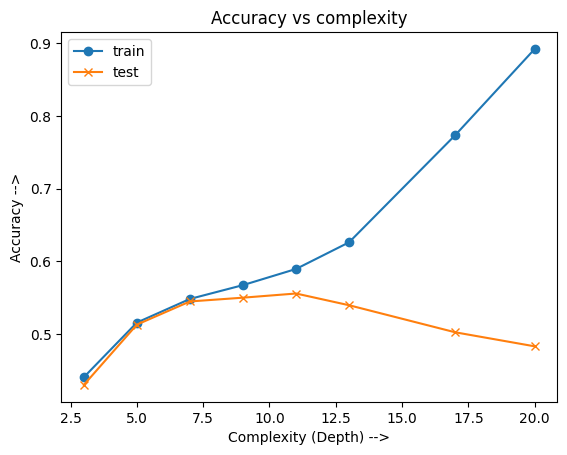

In [61]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p3["X"], p3["Y"], entropy, depth)
    results.append(metrics.print(predictAll(p3["X"], tree), p3["Y"], predictAll(p3["X_test"], tree), p3["Y_test"], visualize=False, result=True))

bestResult_p3_entropy = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 55.57%, F1 Score: 0.56
Confusion Matrix:
[[1599  371  240  330  431]
 [ 473 1604  259  265  380]
 [ 377  327 1744  221  371]
 [ 422  350  236 1655  312]
 [ 431  348  202  319 1733]]


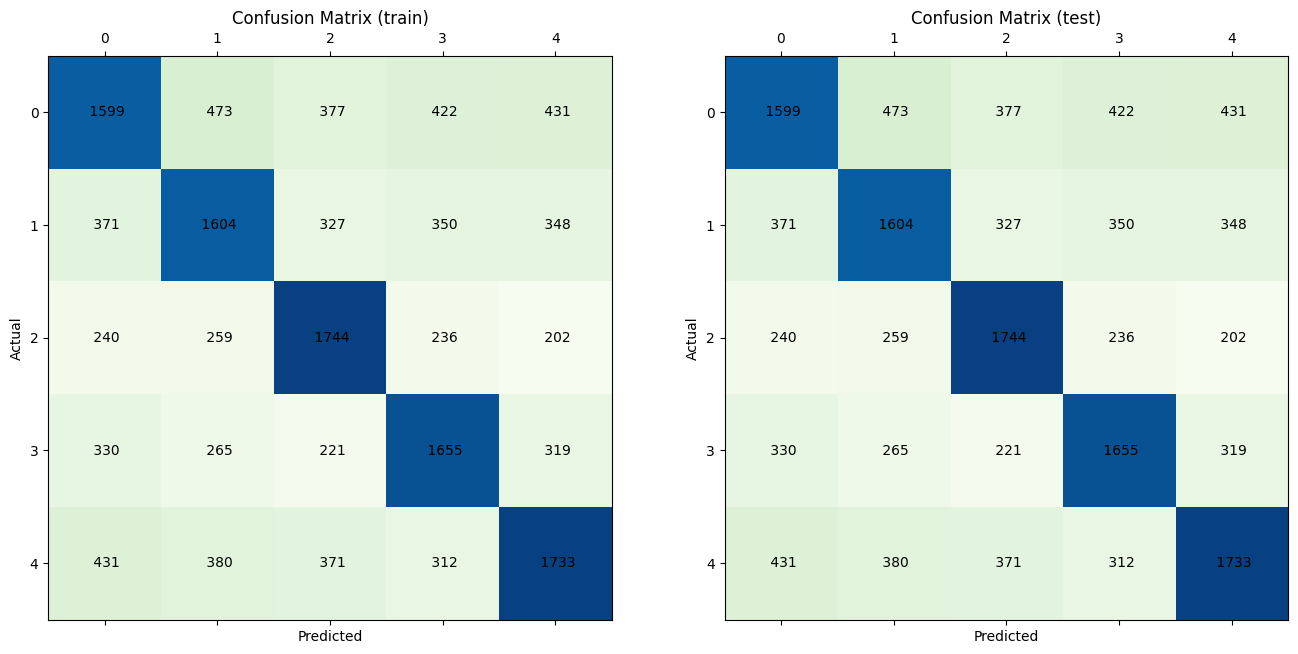

In [82]:
print(f"Test Accuracy: {bestResult_p3_entropy[1][0] * 100:.2f}%, F1 Score: {np.average(bestResult_p3_entropy[1][1]):.2f}")
metrics.printCnf(bestResult_p3_entropy[1][2], bestResult_p3_entropy[1][2])

## Experiment on P5 Data (MNIST PCA)

### Using Gini as impurity measure

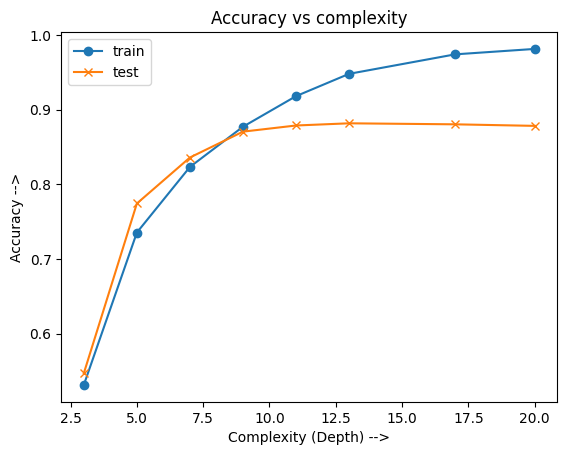

In [74]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p5["X"], p5["Y"], gini, depth)
    results.append(metrics.print(predictAll(p5["X"], tree), p5["Y"], predictAll(p5["X_test"], tree), p5["Y_test"], visualize=False, result=True))

bestResult_p5_gini = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 88.18%, F1 Score: 0.88
Confusion Matrix:
[[2608  219   23   21    3    6    5   19   68   28]
 [ 197 2648   10   23   34    6    4   25   26   27]
 [   8    6 2858   14    0   56    4    6    9   39]
 [  37   44   62 2633   26   60   44   52   29   13]
 [   2    1    1   50 2715  132   12   28    7   52]
 [   6   11   25   42  148 2676    5   11   68    8]
 [   4    0   10   41    9    8 2623  290    3   12]
 [   4    4   75  152   12    9  411 2314    1   18]
 [  94    9    6    4   20   14    4    5 2808   36]
 [  64   51   24   22   90   20   32   69   57 2571]]


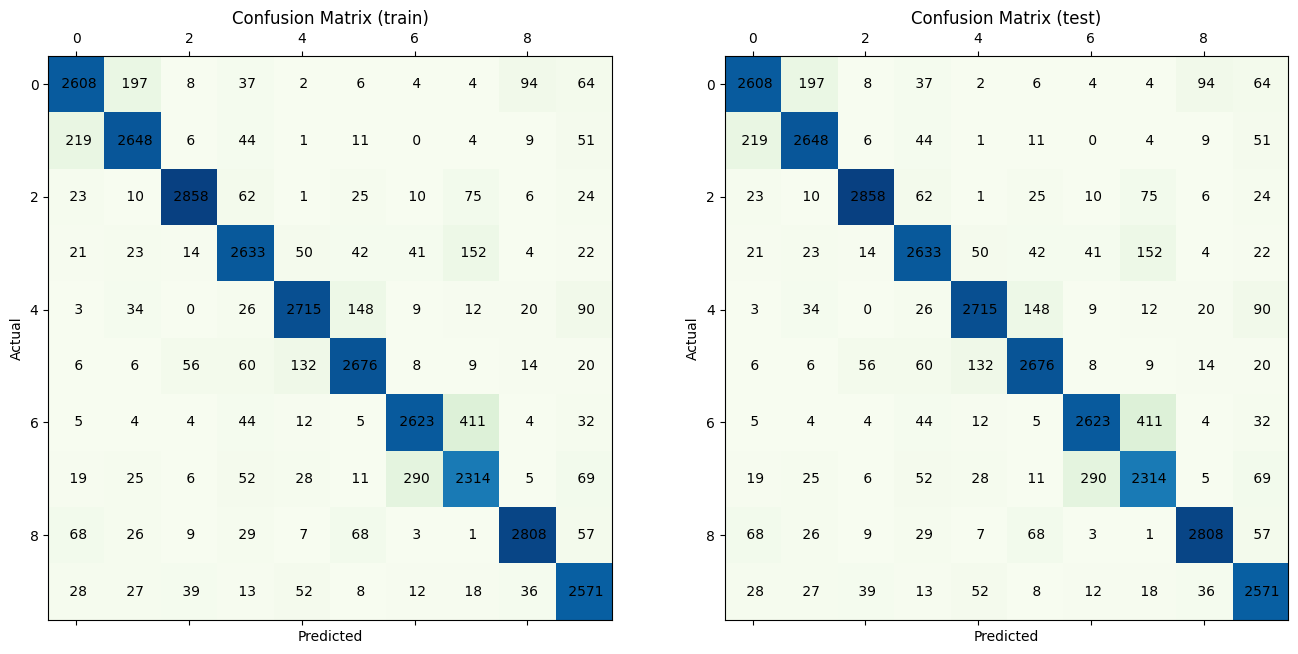

In [84]:
print(f"Test Accuracy: {bestResult_p5_gini[1][0] * 100:.2f}%, F1 Score: {np.average(bestResult_p5_gini[1][1]):.2f}")
metrics.printCnf(bestResult_p5_gini[1][2], bestResult_p5_gini[1][2])

### Using Entropy as impurity measure

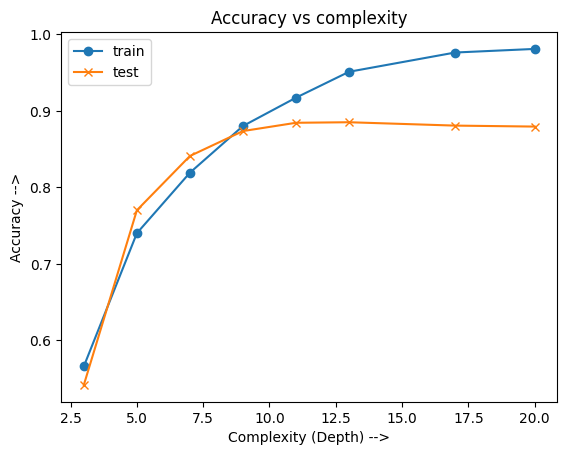

In [76]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p5["X"], p5["Y"], entropy, depth)
    results.append(metrics.print(predictAll(p5["X"], tree), p5["Y"], predictAll(p5["X_test"], tree), p5["Y_test"], visualize=False, result=True))

bestResult_p5_entropy = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 88.52%, F1 Score: 0.89
Confusion Matrix:
[[2612  218   13   34    6    2    3   12   83   17]
 [ 198 2641   15   34   16    4    8   13   44   27]
 [  12    9 2825   18    3   71    5    9   12   36]
 [  26   24   75 2644   27   49   36   71   32   16]
 [   2    2    6   43 2716  119   12   41   21   38]
 [   6   21   60   47  124 2628    8   19   63   24]
 [   3    0   14   40    3   16 2595  305    3   21]
 [   5    0   20  128   19    4  339 2466    0   19]
 [  72   15   10    4   22    8    2    2 2818   47]
 [  52   35   20   15   51   30   29   71   87 2610]]


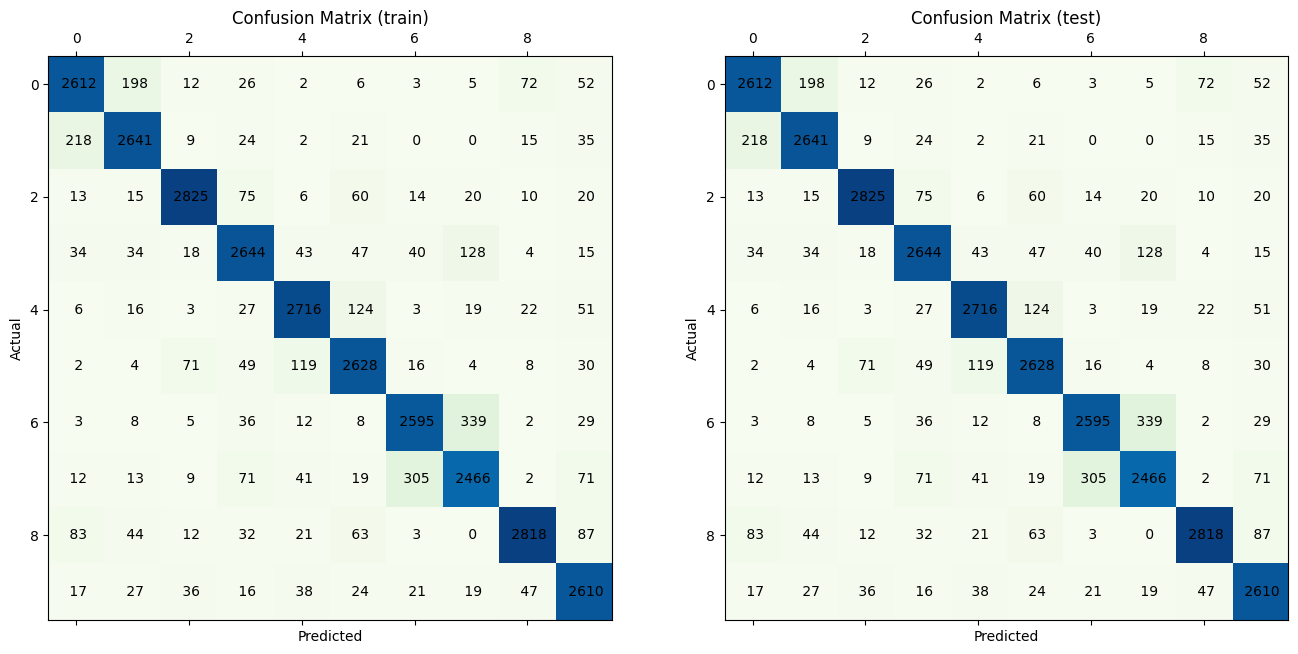

In [79]:
print(f"Test Accuracy: {bestResult_p5_entropy[1][0] * 100:.2f}%, F1 Score: {np.average(bestResult_p5_entropy[1][1]):.2f}")
metrics.printCnf(bestResult_p5_entropy[1][2], bestResult_p5_entropy[1][2])

# Problem 2

Implement Random forest Algorithm with varying numbers of trees and features and report your observations

Data: `p3, p4, p5`

# Problem 3

Implement the Adaboost algorithm with at least 3 learners and one of them must be a Neural Network (MLP/CNN). 

Report the comparison between this and using only one classifier. 

Plot the convergence of train error as a function of the number of learners.

Data: `p3, p4, p5`

# Problem 4

Consider the KMNIST data and implement 

    (a) GMM-based clustering, 
    
    (b) K means clustering.
    
Evaluate and compare the Normalized Mutual Information for both algorithms. 

Experiment with different number of cluster sizes and plot the t-sne plots for all cases.

Data: `p3, p4, p5`

# Problem 5

Implement Principal Component Analysis on KMNIST. 

Plot the data variance as a function of the number of principal components.

Data: `p3, p4, p5`